In [63]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from itertools import combinations

from xgboost import XGBClassifier
import lightgbm as lgb

## Data Fetching

In [14]:
raw = pd.read_csv('tr_eikon_eod_data.csv', 
                 index_col = 0, parse_dates = True)

In [15]:
colnames = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
tickers = ["AAPL", "MSFT", "INTC", "AMZN", "GS"]

### External data

*Dropped due to lack of improvement

In [16]:
# ext_data = yf.download("AAPL MSFT INTC AMZN GS", start="2010-01-01", end="2018-07-01")

# print(ext_data.info())

In [17]:
data = raw[colnames]

# print(ext_data["Open"]["AAPL"])
# print(ext_data["Close"]["AAPL"])
# print(ext_data["High"]["AAPL"])
# print(ext_data["Low"]["AAPL"])
# print(data["AAPL.O"])
# print(data[data.isna().any(axis=1)])
# print(ext_data["Close"])

rets = pd.DataFrame()

for stock in colnames:
    data[f"{stock} ret"] = np.log(data[stock] / data[stock].shift(1))

data.dropna(inplace=True)    

for stock in colnames:
    data[f"{stock} dir"] = np.sign(data[f"{stock} ret"]).astype(int)

## Feature Engineering

### Lag returns

In [18]:
stock_bins = {}

for stock in colnames:
    mean = data[f'{stock} ret'].mean()
    std = data[f'{stock } ret'].std()
    stock_bins[stock] = [mean - std, mean, mean + std]

lag_feat = []
for stock in colnames:
    for i in range(1,11):
        feat = f'{stock} lag_' + str(i)
        data[feat] = np.digitize(data[f'{stock} ret'].shift(i), stock_bins[stock])
        lag_feat.append(feat)

### RSI calculation

In [19]:
def calculate_rsi(prices, period=14):
    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)
    
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

rsi_bins = {}

for stock in colnames:
    feat = f"{stock} rsi"
    data[feat] = calculate_rsi(data[stock])
    mean = data[feat].mean()
    std = data[feat].std()
    rsi_bins[stock] = [mean - std, mean, mean + std]
    
    data[feat] = data[feat].shift(1)

rsi_feat = [f"{stock} rsi"]

### Short and Long Simple Moving Average as buy / sell signals

In [20]:
def moving_average(data, window_short=20, window_long=100):
    """
    Calculate short-term and long-term moving averages.

    Parameters:
    - data: List or array-like object containing the time series data.
    - window_short: Integer specifying the window size for the short-term moving average.
    - window_long: Integer specifying the window size for the long-term moving average.

    Returns:
    - short_ma: List containing the short-term moving averages.
    - long_ma: List containing the long-term moving averages.
    """

    # Calculate short-term moving average
    short_ma = data.rolling(window=window_short).mean()

    # Calculate long-term moving average
    long_ma = data.rolling(window=window_long).mean()

    return short_ma, long_ma

for stock in colnames:
    short, long = moving_average(data[stock])
    data[f'{stock} SMA'] = np.where(short > long, 1, -1)
    data[f"{stock} SMA"] = data[f"{stock} SMA"].shift(-100).shift(101)

ma_feat = [f"{stock} SMA" for stock in colnames]


### Simple Moving Average as breakpoint

In [21]:
def simple_sma_trade(data, window=125, tolerance=0.01):
    sma = data.rolling(window=window).mean()
    threshold = tolerance * sma

    return np.where(data > sma, 1, -1)

for stock in colnames:
    data[f"{stock} SMA trade"] = simple_sma_trade(data[stock])
    data[f"{stock} SMA trade"] = data[f"{stock} SMA trade"].shift(-125).shift(126)

sma_feat = [f"{stock} SMA trade" for stock in colnames]

### Moving Average Convergence Divergence (MACD)

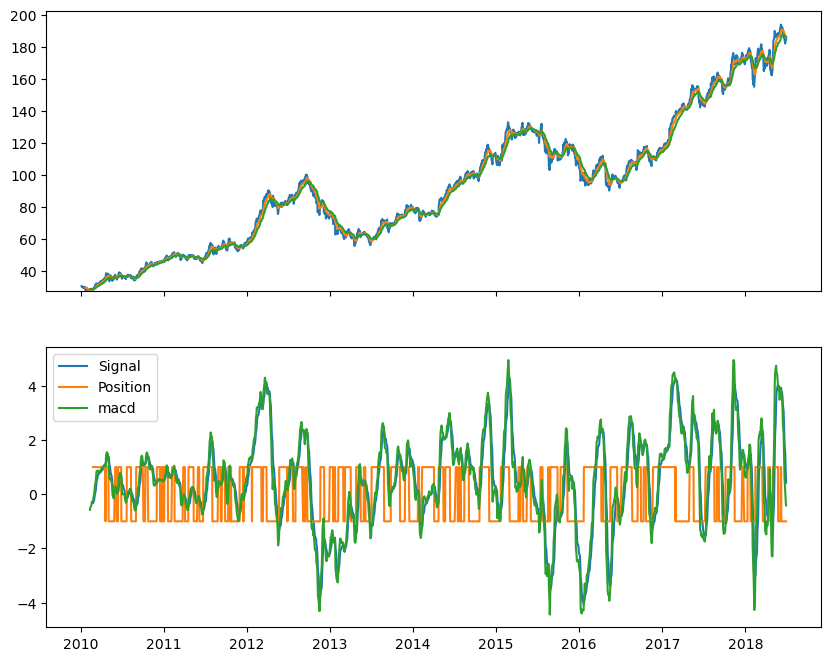

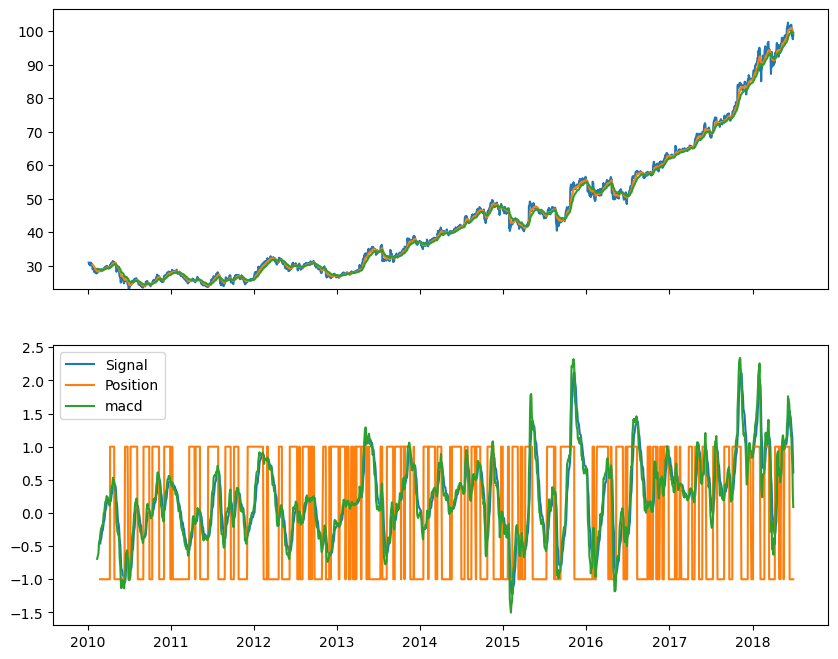

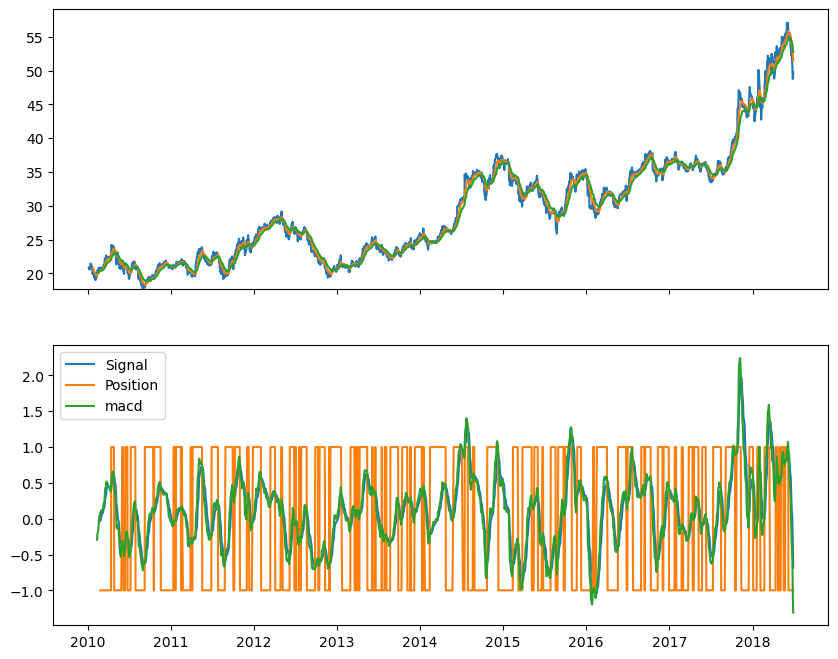

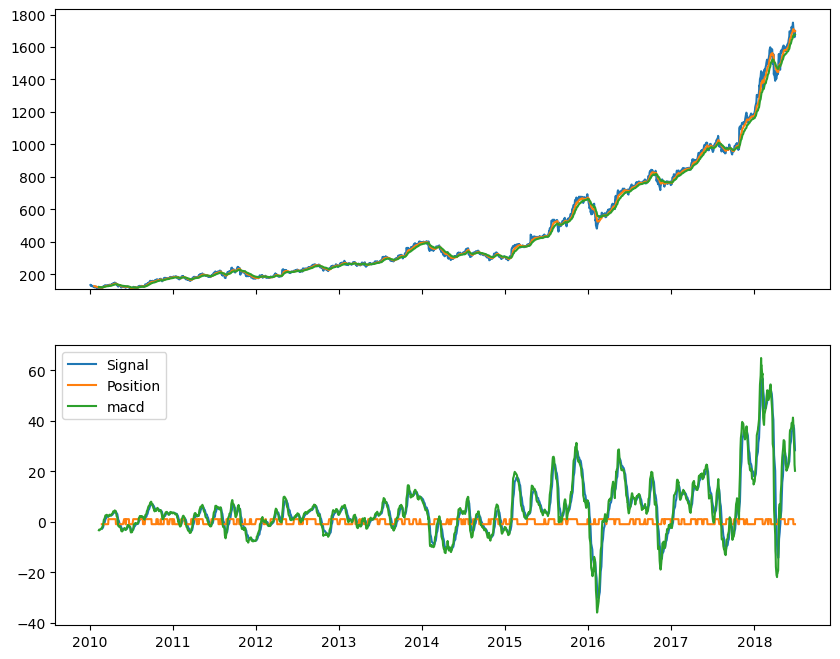

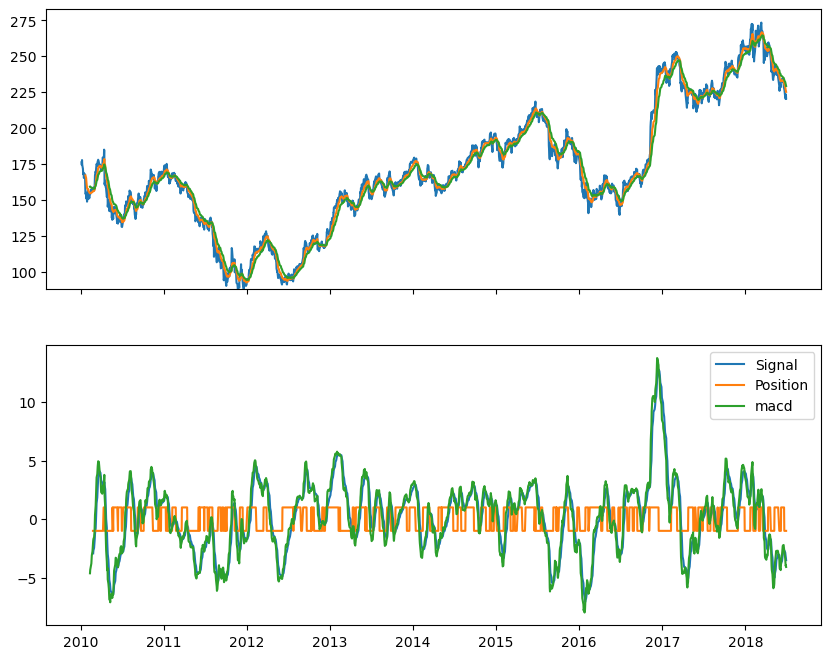

In [22]:
def calculate_macd(data, short_window=12, long_window=26, signal_window = 9, initial = 1):
    short_ema = data.ewm(span=short_window, adjust=False, min_periods=short_window).mean()
    long_ema = data.ewm(span=long_window, adjust=False, min_periods=long_window).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False, min_periods=signal_window).mean()

    histogram = macd - signal

    positions = []
    position = initial

    for i in range(long_window + signal_window - 2, len(data)):
        if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
            position = 1
        elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
            position = -1
        positions.append(position)

    positions.insert(0, initial)

    pos = pd.DataFrame(index=data.index)
    pos["position"] = np.nan
    pos.iloc[:long_window + signal_window -3] = np.nan
    pos.iloc[long_window + signal_window - 3:, 0] = positions

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    # Plot stock price
    ax1.plot(data, label="Stock Price")

    # Plot short EMA, long EMA, and signal
    ax1.plot(short_ema, label="Short EMA")
    ax1.plot(long_ema, label="Long EMA")
    ax1.set_ylim(data.min())

    ax2.plot(signal, label="Signal")

    # Plot position (scaled for better visualization)
    ax2.plot(pos, label="Position")
    ax2.plot(macd, label="macd")
    

    plt.legend()

    return pos

for stock in colnames:
    data[f"{stock} MACD"] = calculate_macd(data[stock], initial=data[f"{stock} dir"][26 + 9 - 2])
    data[f"{stock} MACD"] = data[f"{stock} MACD"].shift(1)

MACD_feat = [f"{stock} MACD" for stock in colnames]





### Post processing for RSI

In [23]:
feat_data = data.dropna()

for stock in colnames:
    feat = f"{stock} digi-rsi"
    rsi = f"{stock} rsi"
    feat_data[feat] = np.digitize(feat_data[rsi], bins=rsi_bins[stock])

rsi_feat = [f"{stock} digi-rsi" for stock in colnames]

## Results

In [24]:
def print_data(string, data):
    print("-" * 100)
    print(string)
    print("-" * 100)
    print(data)

### Predicting positions on all 5 stocks at once

----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.112759
MSFT.O ret    0.781146
INTC.O ret    1.128317
AMZN.O ret    0.991707
GS.N ret      1.068941
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    0.902497
MSFT.O ret    0.964971
INTC.O ret    1.240064
AMZN.O ret    0.743015
GS.N ret      0.964861
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    192
MSFT.O dir    195
INTC.O dir    180
AMZN.O dir    198
GS.N dir    

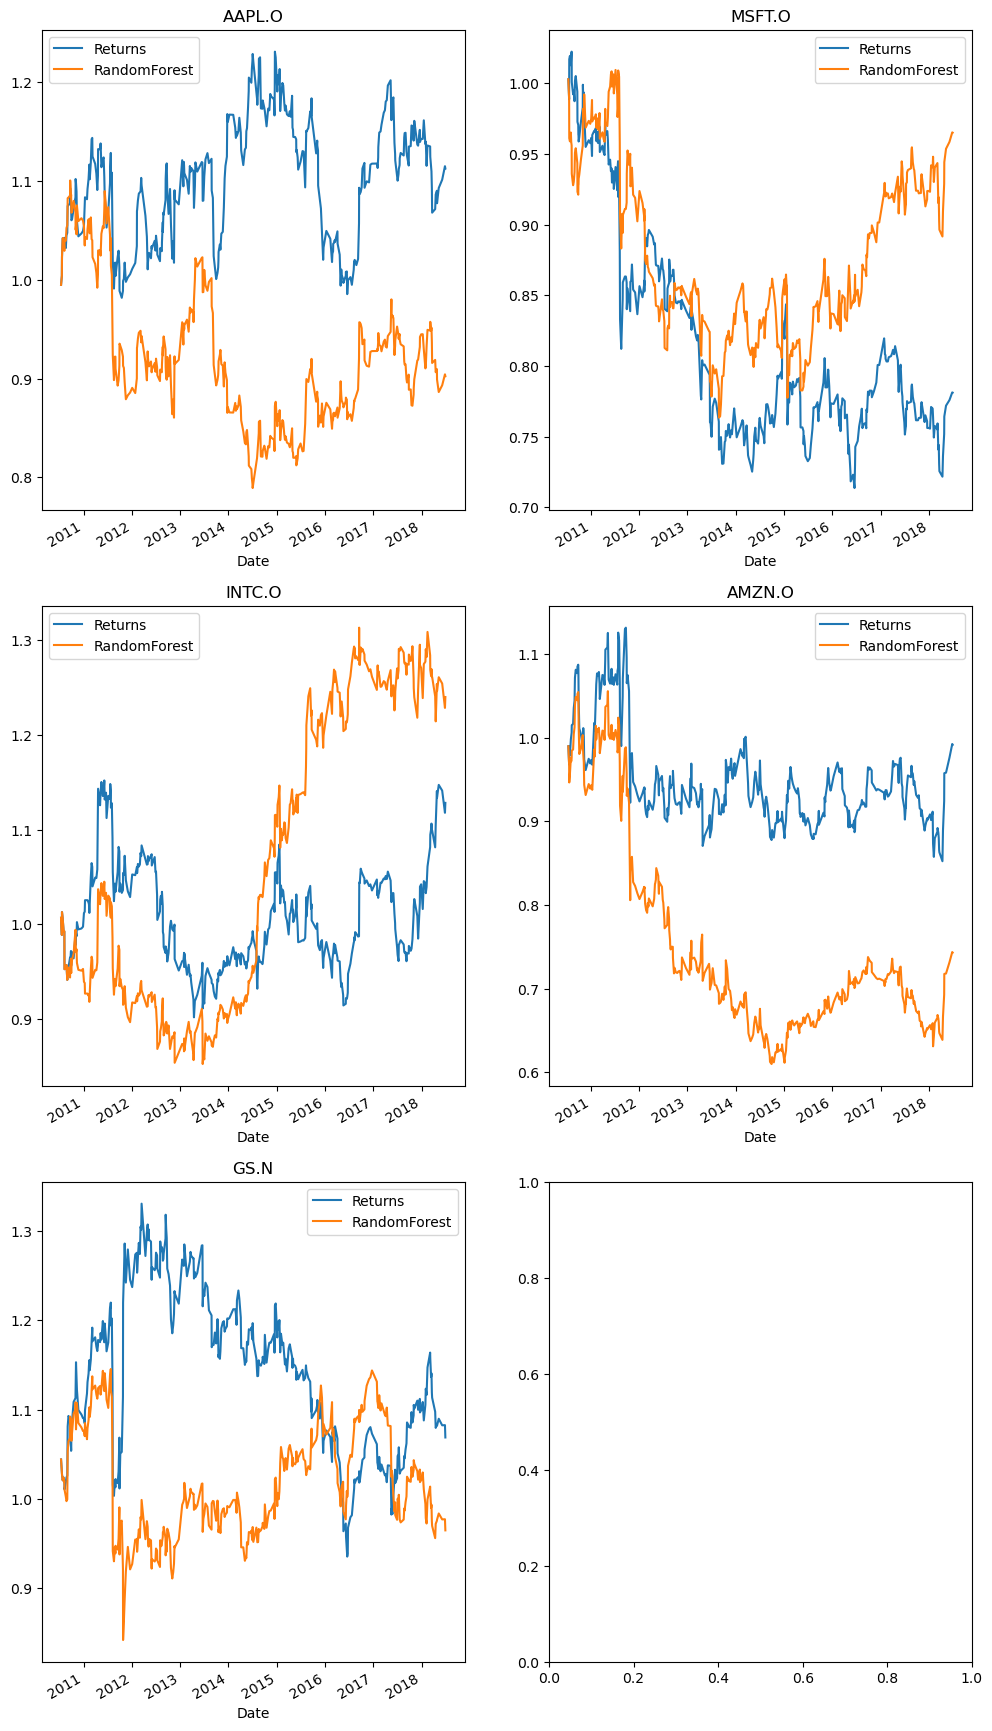

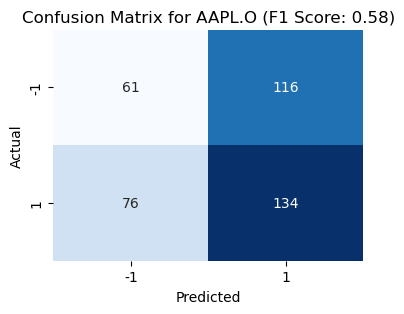

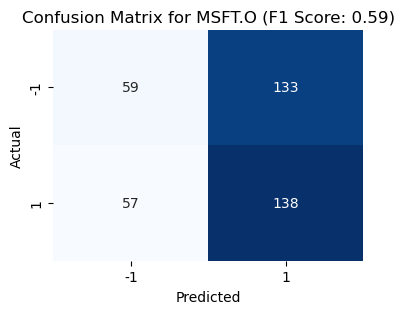

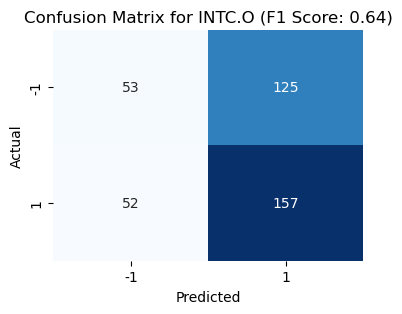

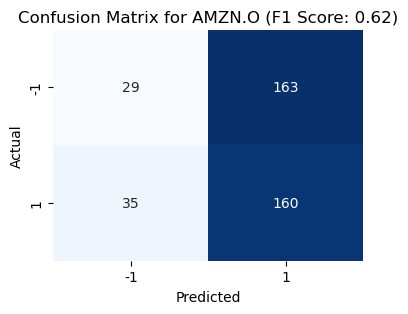

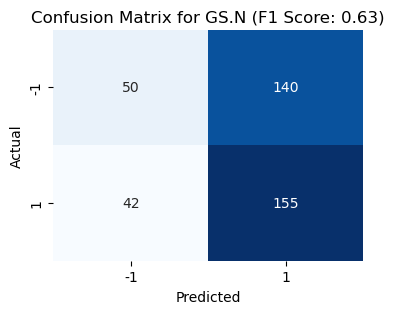

In [51]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + rsi_feat

roll = 1
# test_split = len(data) // 5

# data_train = feat_data[:- test_split]
# data_test = feat_data[-test_split:]

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

model.fit(training, training_res)

preds = model.predict(testing)
results = pd.DataFrame(data=preds).rolling(window=roll, min_periods=1).apply(lambda x: mode(x)[0]).values


print_data("Returns:", data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print_data("RandomForest returns:", (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))

print_data("False predictions:", (results != data_test[[f"{stock} dir" for stock in colnames]]).sum())

print_data("Total rows:", results.shape[0])

feature_importances = model.feature_importances_
# print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    # (data_test[f"{stock} ret"] * data_test[f"{stock} dir"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="Optimal")
    
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()



----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.112759
MSFT.O ret    0.781146
INTC.O ret    1.128317
AMZN.O ret    0.991707
GS.N ret      1.068941
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.187334
MSFT.O ret    1.160803
INTC.O ret    1.073879
AMZN.O ret    1.483176
GS.N ret      0.990290
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    194
MSFT.O dir    193
INTC.O dir    187
AMZN.O dir    187
GS.N dir    

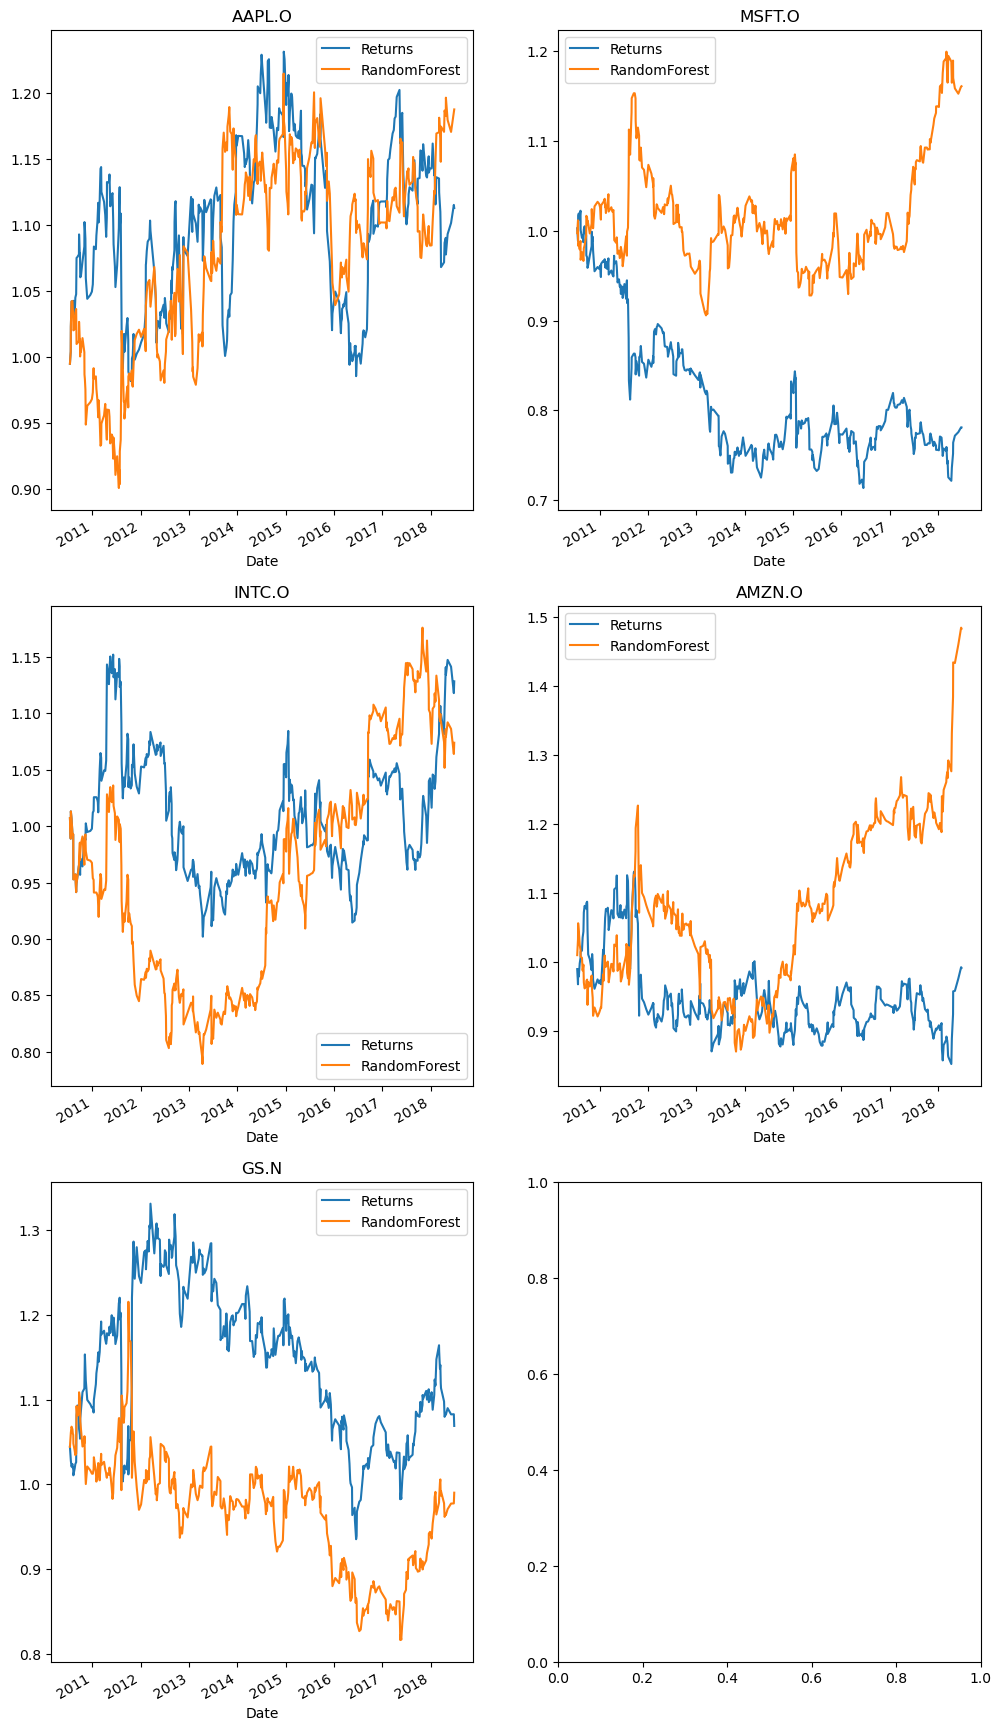

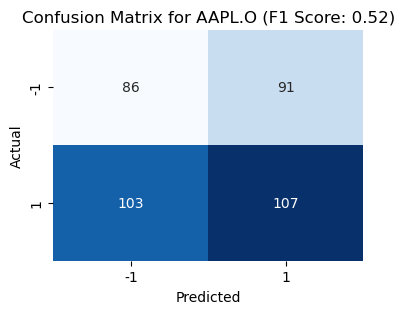

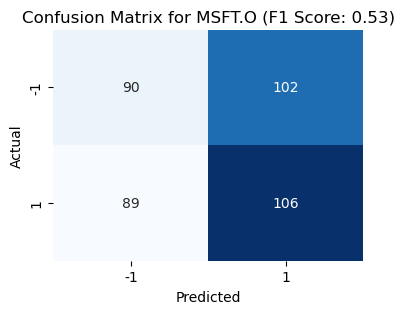

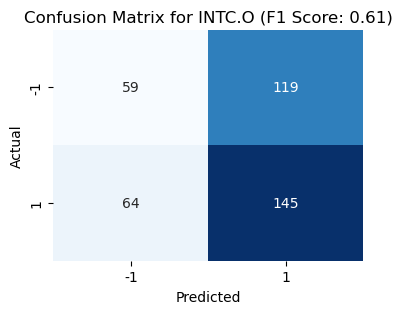

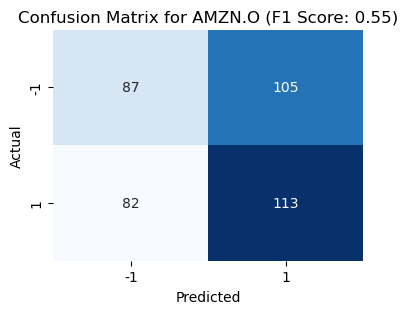

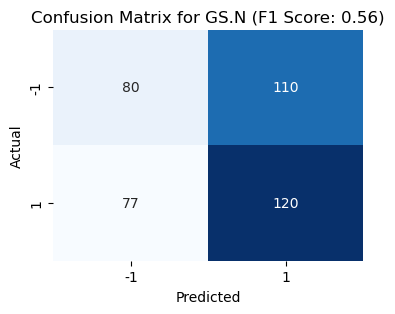

In [61]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + rsi_feat + sma_feat + lag_feat + MACD_feat

roll = 1
# test_split = len(data) // 5

# data_train = feat_data[:- test_split]
# data_test = feat_data[-test_split:]

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

model.fit(training, np.where(training_res == -1, 0, 1))

preds = np.where(model.predict(testing) == 0, -1, 1)
results = pd.DataFrame(data=preds).rolling(window=roll, min_periods=1).apply(lambda x: mode(x)[0]).values


print_data("Returns:", data_test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp))

print_data("RandomForest returns:", (results * data_test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp))

print_data("False predictions:", (results != data_test[[f"{stock} dir" for stock in colnames]]).sum())

print_data("Total rows:", results.shape[0])

feature_importances = model.feature_importances_
# print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=features, columns=["Importance"]).sort_values("Importance", ascending=False))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:,i] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    # (data_test[f"{stock} ret"] * data_test[f"{stock} dir"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="Optimal")
    
    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

def calculate_f1_score(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return f1_score

# Iterate over each column and create confusion matrix
for i, stock in enumerate(colnames):
    # Create confusion matrix
    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, i]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    plt.show()



### Predicting positions on each stock individually with their features

AAPL.O
----------------------------------------------------------------------------------------------------
Returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.112759
dtype: float64
----------------------------------------------------------------------------------------------------
RandomForest returns:
----------------------------------------------------------------------------------------------------
AAPL.O ret    1.191408
dtype: float64
----------------------------------------------------------------------------------------------------
False predictions:
----------------------------------------------------------------------------------------------------
AAPL.O dir    194
dtype: int64
----------------------------------------------------------------------------------------------------
Total rows:
----------------------------------------------------------------------------------------------------
387
MSFT.O
-----

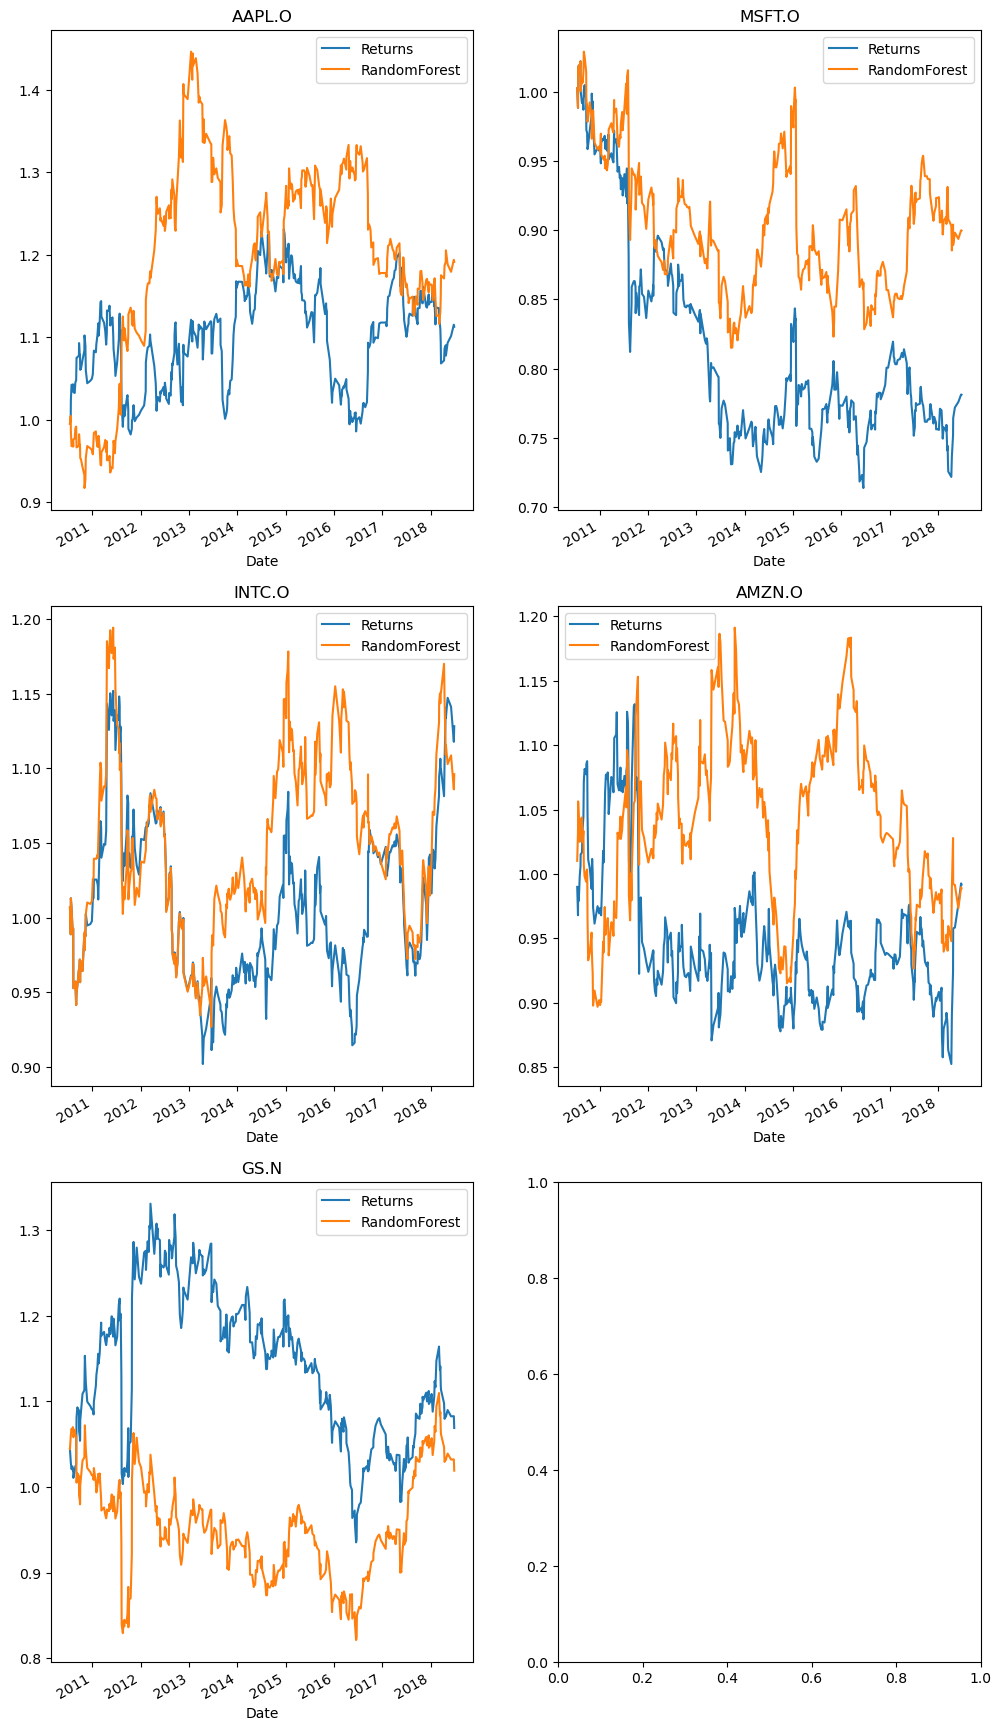

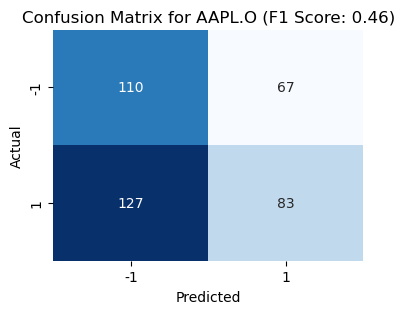

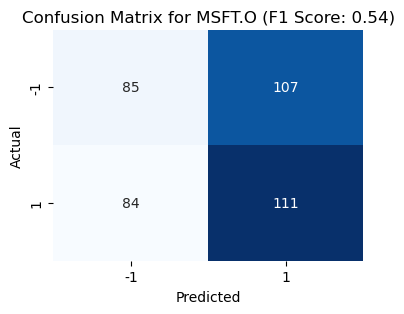

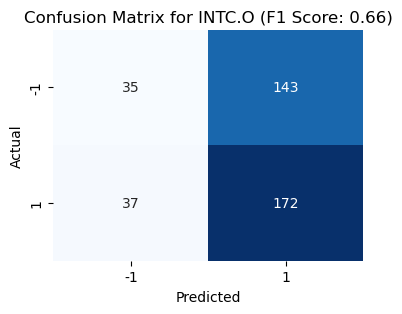

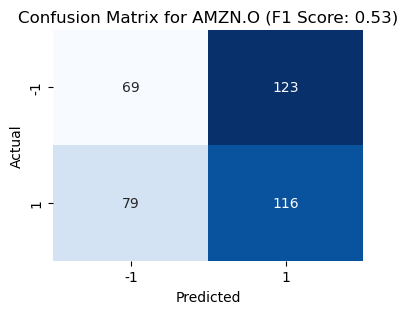

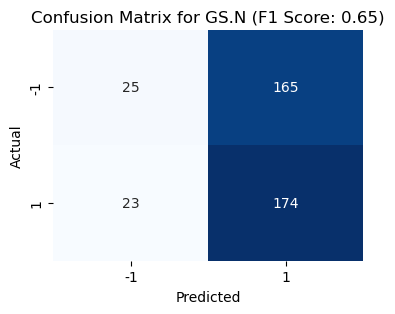

In [50]:
data_train, data_test = train_test_split(feat_data, 
                                         test_size = 0.2,
                                         random_state = 0)
features = ma_feat + rsi_feat

roll = 1

data_train = data_train.copy().sort_index()
data_test = data_test.copy().sort_index()

training = data_train[features]
testing = data_test[features]

training_res = data_train[[f"{stock} dir" for stock in colnames]]
testing_res = data_test[[f"{stock} dir" for stock in colnames]]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,24))

for i, stock in enumerate(colnames):
    feat = list(filter(lambda x: stock in x, features))

    model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

    model.fit(training[feat], training_res[f"{stock} dir"])

    preds = model.predict(testing[feat])
    results = pd.DataFrame(data=preds).rolling(window=roll, min_periods=1).apply(lambda x: mode(x)[0]).values

    print(stock)
    print_data("Returns:", data_test[[f"{stock} ret"]].sum().apply(np.exp))
    print_data("RandomForest returns:", (results * data_test[[f"{stock} ret"]]).sum().apply(np.exp))
    print_data("False predictions:", (results != data_test[[f"{stock} dir"]]).sum())
    print_data("Total rows:", results.shape[0])

    feature_importances = model.feature_importances_
    # print_data("Feature importance:", pd.DataFrame(data=feature_importances, index=feat, columns=["Importance"]).sort_values("Importance", ascending=False))

    data_test[f"{stock} ret"].cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="returns")
    (results[:, 0] * data_test[f"{stock} ret"]).cumsum().apply(np.exp).plot(ax=axes[i // 2, i % 2], label="RandomForest")

    axes[i // 2, i % 2].legend(["Returns", "RandomForest"])
    axes[i // 2, i % 2].set_title(stock)

    conf_matrix = np.zeros((2, 2))
    for actual, predicted in zip(data_test[f"{stock} dir"].values, results[:, 0]):
        actual_index = 0 if actual == -1 else 1
        predicted_index = 0 if predicted == -1 else 1
        conf_matrix[actual_index, predicted_index] += 1

    # Calculate F1 score
    f1_score = calculate_f1_score(conf_matrix)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=['-1', '1'], yticklabels=['-1', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {stock} (F1 Score: {f1_score:.2f})')
    
plt.show()

### Simulations

In [27]:
def simulate_model(it, stocks=colnames, data=feat_data, train=data_train, test=data_test, ran_split=False, feat=features, rerun=0, rolling_parse=1):

    lst = []
    for stock in stocks:
        lst += list(filter(lambda x: stock in x, feat))
    feat = lst

    sim = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    improv = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    false_pred = np.zeros((it * (1 + rerun), len(stocks)))
    f1s = np.zeros((it * (1 + rerun), len(stocks)))
    imp = pd.DataFrame(index=feat)
    run = 0

    while True:
        if ran_split:
            train, test = train_test_split(data, 
                                                test_size = 0.2)

        train = train.copy().sort_index()
        test = test.copy().sort_index()

        training = train[feat]
        testing = test[feat]

        training_res = train[[f"{stock} dir" for stock in stocks]]

        for i in range(it):
            model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
            model.fit(training, training_res)

            results = model.predict(testing)
            results = pd.DataFrame(data=results).rolling(window=rolling_parse, min_periods=1).apply(lambda x: mode(x)[0]).values
            rets = test[[f"{stock} ret" for stock in stocks]].sum().apply(np.exp)

            pred_rets = (results * test[[f"{stock} ret" for stock in stocks]]).sum().apply(np.exp)

            sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

            improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
            false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in stocks]]).sum()

            importances = pd.Series(model.feature_importances_, index=training.columns)
            imp = pd.concat([imp, importances], axis=1)

            for j, stock in enumerate(stocks):
                # Create confusion matrix
                conf_matrix = np.zeros((2, 2))
                for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
                    actual_index = 0 if actual == -1 else 1
                    predicted_index = 0 if predicted == -1 else 1
                    conf_matrix[actual_index, predicted_index] += 1

                # Calculate F1 score
                f1_score = calculate_f1_score(conf_matrix)
                f1s[i + run * it, j] = f1_score
        run += 1
        if run <= rerun:
            continue
        else:
            break

    false_pred = pd.DataFrame(data=false_pred, columns=[stock for stock in stocks], index=[j for j in range(it * (1 + rerun))])

    sorted_imp = (imp.sum(axis=1) / (it * (1 + rerun))).sort_values(ascending=False)

    print_data("Mean improvement: ", sim.mean())

    # print_data("std dev of improvements: ", sim.std())

    print_data("Mean total returns: ", sim.sum(axis=1).mean())

    print_data("Number of improvements: ", improv.replace(-1, 0).sum(axis=0))

    # print_data("Mean false predictions: ", false_pred.mean())

    # print_data("std dev false predictions: ", false_pred.std())

    # print_data("Mean feature importance", sorted_imp)

    # print_data("std dev feature importance", imp.std(axis=1).reindex(sorted_imp.index))

    print_data("Mean f1 score:", pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1" for stock in stocks]))

    print_data("std dev of f1 scores: ", pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1" for stock in stocks]))

In [59]:
def simulate_model(it, stocks=colnames, data=feat_data, train=data_train, test=data_test, ran_split=False, feat=features, rerun=0, rolling_parse=1):

    lst = []
    for stock in stocks:
        lst += list(filter(lambda x: stock in x, feat))
    feat = lst

    sim = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    improv = pd.DataFrame(columns=[f"{stock} ret" for stock in stocks])
    false_pred = np.zeros((it * (1 + rerun), len(stocks)))
    f1s = np.zeros((it * (1 + rerun), len(stocks)))
    imp = pd.DataFrame(index=feat)
    run = 0

    while True:
        if ran_split:
            train, test = train_test_split(data, 
                                                test_size = 0.2)

        train = train.copy().sort_index()
        test = test.copy().sort_index()

        training = train[feat]
        testing = test[feat]

        training_res = train[[f"{stock} dir" for stock in stocks]]

        for i in range(it):
            model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
            model.fit(training, np.where(training_res == -1, 0, 1))

            results = np.where(model.predict(testing) == 0, -1, 1)
            results = pd.DataFrame(data=results).rolling(window=rolling_parse, min_periods=1).apply(lambda x: mode(x)[0]).values
            rets = test[[f"{stock} ret" for stock in stocks]].sum().apply(np.exp)

            pred_rets = (results * test[[f"{stock} ret" for stock in stocks]]).sum().apply(np.exp)

            sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

            improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
            false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in stocks]]).sum()

            importances = pd.Series(model.feature_importances_, index=training.columns)
            imp = pd.concat([imp, importances], axis=1)

            for j, stock in enumerate(stocks):
                # Create confusion matrix
                conf_matrix = np.zeros((2, 2))
                for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
                    actual_index = 0 if actual == -1 else 1
                    predicted_index = 0 if predicted == -1 else 1
                    conf_matrix[actual_index, predicted_index] += 1

                # Calculate F1 score
                f1_score = calculate_f1_score(conf_matrix)
                f1s[i + run * it, j] = f1_score
        run += 1
        if run <= rerun:
            continue
        else:
            break

    false_pred = pd.DataFrame(data=false_pred, columns=[stock for stock in stocks], index=[j for j in range(it * (1 + rerun))])

    sorted_imp = (imp.sum(axis=1) / (it * (1 + rerun))).sort_values(ascending=False)

    print_data("Mean improvement: ", sim.mean())

    # print_data("std dev of improvements: ", sim.std())

    print_data("Mean total returns: ", sim.sum(axis=1).mean())

    print_data("Number of improvements: ", improv.replace(-1, 0).sum(axis=0))

    # print_data("Mean false predictions: ", false_pred.mean())

    # print_data("std dev false predictions: ", false_pred.std())

    # print_data("Mean feature importance", sorted_imp)

    # print_data("std dev feature importance", imp.std(axis=1).reindex(sorted_imp.index))

    print_data("Mean f1 score:", pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1" for stock in stocks]))

    print_data("std dev of f1 scores: ", pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1" for stock in stocks]))

#### Simulation parameters

In [28]:
itr = 1
reruns = 300
ran_split = True
roll = 3

#### Single stock prediction simulations

In [29]:
simulate_model(itr, stocks=["AAPL.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.138625
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.13862508644312146
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret    99
dtype: int64
----------------------------------------------------------------------------------------------------
Mean f1 score:
----------------------------------------------------------------------------------------------------
                  0
AAP

In [30]:
simulate_model(itr, stocks=["MSFT.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
MSFT.O ret   -0.191703
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.19170316599931336
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
MSFT.O ret    92
dtype: int64
----------------------------------------------------------------------------------------------------
Mean f1 score:
----------------------------------------------------------------------------------------------------
                  0
MSF

In [31]:
simulate_model(itr, stocks=["INTC.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
INTC.O ret   -0.094356
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.09435608289627544
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
INTC.O ret    130
dtype: int64
----------------------------------------------------------------------------------------------------
Mean f1 score:
----------------------------------------------------------------------------------------------------
                  0
IN

In [32]:
simulate_model(itr, stocks=["AMZN.O"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AMZN.O ret   -0.210516
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.21051641535539486
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AMZN.O ret    88
dtype: int64
----------------------------------------------------------------------------------------------------
Mean f1 score:
----------------------------------------------------------------------------------------------------
                  0
AMZ

In [33]:
simulate_model(itr, stocks=["GS.N"], ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
GS.N ret   -0.074963
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.07496265335023145
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
GS.N ret    136
dtype: int64
----------------------------------------------------------------------------------------------------
Mean f1 score:
----------------------------------------------------------------------------------------------------
                0
GS.N f1 

#### Multi-stock prediction simulation

In [62]:
simulate_model(itr, ran_split=ran_split, rerun=reruns, rolling_parse=roll)

----------------------------------------------------------------------------------------------------
Mean improvement: 
----------------------------------------------------------------------------------------------------
AAPL.O ret   -0.252808
MSFT.O ret   -0.160168
INTC.O ret    0.179774
AMZN.O ret   -0.447705
GS.N ret     -0.097010
dtype: float64
----------------------------------------------------------------------------------------------------
Mean total returns: 
----------------------------------------------------------------------------------------------------
-0.7779168538358733
----------------------------------------------------------------------------------------------------
Number of improvements: 
----------------------------------------------------------------------------------------------------
AAPL.O ret     83
MSFT.O ret    100
INTC.O ret    212
AMZN.O ret     61
GS.N ret      116
dtype: int64
----------------------------------------------------------------------------

## Fine-tuning

### Fine-tuning: SMA short and long

In [35]:
# sma_windows = [3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 200, 250]

# for stock in colnames:
#     for i in sma_windows:
#         data[f"{stock} SMA {i}"] = data[stock].rolling(window=i).mean().shift(1)

In [36]:
# table = pd.DataFrame()
# it = 50
# rerun = 50
# ran_split = True
# feat = features

# for n in range(len(sma_windows)):
#     for m in range(n + 1,len(sma_windows)):
#         label = f"{sma_windows[n]} and {sma_windows[m]}"

#         for stock in colnames:
#             feat_data[f'{stock} SMA'] = np.where(feat_data[f"{stock} SMA {sma_windows[n]}"] >= feat_data[f"{stock} SMA {sma_windows[m]}"], 1, -1)
            
#         sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#         false_pred = np.zeros((it * (1 + rerun), 5))
#         f1s = np.zeros((it * (1 + rerun), 5))
#         imp = pd.DataFrame(index=feat)
#         run = 0

#         while True:
#             if ran_split:
#                 train, test = train_test_split(feat_data, 
#                                                     test_size = 0.2)

#             train = train.copy().sort_index()
#             test = test.copy().sort_index()

#             training = train[feat]
#             testing = test[feat]

#             for i in range(it):
#                 model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
#                 model.fit(training, training_res)

#                 results = model.predict(testing)
#                 rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#                 pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#                 sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#                 improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#                 false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#                 importances = pd.Series(model.feature_importances_, index=training.columns)
#                 imp = pd.concat([imp, importances], axis=1)

#                 for j, stock in enumerate(colnames):
#                     # Create confusion matrix
#                     conf_matrix = np.zeros((2, 2))
#                     for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                         actual_index = 0 if actual == -1 else 1
#                         predicted_index = 0 if predicted == -1 else 1
#                         conf_matrix[actual_index, predicted_index] += 1

#                     # Calculate F1 score
#                     f1_score = calculate_f1_score(conf_matrix)
#                     f1s[i + run * it, j] = f1_score
#             run += 1
#             if run <= rerun:
#                 continue
#             else:
#                 break

#         false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#         imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#         imp_mean.index = [f"{imp} mean imp" for imp in feat]

#         ret_mean = sim.mean()
#         ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#         improv.columns = [f"{stock} improvs" for stock in colnames]

#         summary = pd.concat([ret_mean, 
#                              sim.std(), 
#                              improv.replace(-1, 0).sum(axis=0), 
#                              false_pred.mean(), false_pred.std(), 
#                              imp_mean, 
#                              imp.std(axis=1), 
#                              pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                              pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                              axis=0)
#         summary.columns = [label]

#         table = pd.concat([table, summary.T], axis=0)

# table.to_csv("SMA_long_short_grid_search.csv", sep=',')

In [37]:
# opt_ratios = []

# for stock in colnames:
#     opt_ratios.append(table.sort_values(by=f"{stock} mean ret", ascending=False).head(10))
#     opt_ratios.append(table.sort_values(by=f"{stock} improvs", ascending=False).head(10))

# for i in opt_ratios:
#     print("-" * 100)
#     print("-" * 100)
#     print(i)

In [38]:
# table.to_csv("grid_search.csv", sep=',')

### Finetuning: SMA breakpoint feature

In [39]:
# table = pd.DataFrame()
# it = 50
# rerun = 50
# ran_split = True
# feat = features

# for n in range(len(sma_windows)):
#     label = f"{sma_windows[n]}"

#     for stock in colnames:
#         feat_data[f'{stock} SMA trade'] = feat_data[f"{stock} SMA {sma_windows[n]} trade"]
        
#     sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     false_pred = np.zeros((it * (1 + rerun), 5))
#     f1s = np.zeros((it * (1 + rerun), 5))
#     imp = pd.DataFrame(index=feat)
#     run = 0

#     while True:
#         if ran_split:
#             train, test = train_test_split(feat_data, 
#                                                 test_size = 0.2)

#         train = train.copy().sort_index()
#         test = test.copy().sort_index()

#         training = train[feat]
#         testing = test[feat]

#         for i in range(it):
#             model = RandomForestClassifier(max_depth=5, min_samples_leaf=5)
#             model.fit(training, training_res)

#             results = model.predict(testing)
#             rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#             pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#             sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#             improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#             false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#             importances = pd.Series(model.feature_importances_, index=training.columns)
#             imp = pd.concat([imp, importances], axis=1)

#             for j, stock in enumerate(colnames):
#                 # Create confusion matrix
#                 conf_matrix = np.zeros((2, 2))
#                 for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                     actual_index = 0 if actual == -1 else 1
#                     predicted_index = 0 if predicted == -1 else 1
#                     conf_matrix[actual_index, predicted_index] += 1

#                 # Calculate F1 score
#                 f1_score = calculate_f1_score(conf_matrix)
#                 f1s[i + run * it, j] = f1_score
#         run += 1
#         if run <= rerun:
#             continue
#         else:
#             break

#     false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#     imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#     imp_mean.index = [f"{imp} mean imp" for imp in feat]

#     ret_mean = sim.mean()
#     ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#     improv.columns = [f"{stock} improvs" for stock in colnames]

#     summary = pd.concat([ret_mean, 
#                             sim.std(), 
#                             improv.replace(-1, 0).sum(axis=0), 
#                             false_pred.mean(), false_pred.std(), 
#                             imp_mean, 
#                             imp.std(axis=1), 
#                             pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                             pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                             axis=0)
#     summary.columns = [label]

#     table = pd.concat([table, summary.T], axis=0)

# table.to_csv("SMA_trade_grid_search.csv", sep=',')

### Finetuning: Number of lag returns to use

In [40]:
# table = pd.DataFrame()
# it = 1
# rerun = 1000
# ran_split = True

# lags = [i for i in range(0, 11)]

# feat_ = list(filter(lambda x: "lag_" not in x, features))

# for lag in lags:
#     label = f"{lag}"

#     lag_itr = []
#     for j in range(1, lag + 1):
#         for stock in colnames:
#             lag_itr += [f"{stock} lag_{j}"]
#     feat = feat_ + lag_itr
        
#     sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     false_pred = np.zeros((it * (1 + rerun), 5))
#     f1s = np.zeros((it * (1 + rerun), 5))
#     imp = pd.DataFrame(index=feat)
#     run = 0

#     while True:
#         if ran_split:
#             train, test = train_test_split(feat_data, 
#                                                 test_size = 0.2)

#         train = train.copy().sort_index()
#         test = test.copy().sort_index()

#         training = train[feat]
#         testing = test[feat]

#         for i in range(it):
#             model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
#             model.fit(training, training_res)

#             results = model.predict(testing)
#             rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#             pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#             sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#             improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#             false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#             importances = pd.Series(model.feature_importances_, index=training.columns)
#             imp = pd.concat([imp, importances], axis=1)

#             for j, stock in enumerate(colnames):
#                 # Create confusion matrix
#                 conf_matrix = np.zeros((2, 2))
#                 for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                     actual_index = 0 if actual == -1 else 1
#                     predicted_index = 0 if predicted == -1 else 1
#                     conf_matrix[actual_index, predicted_index] += 1

#                 # Calculate F1 score
#                 f1_score = calculate_f1_score(conf_matrix)
#                 f1s[i + run * it, j] = f1_score
#         run += 1
#         if run <= rerun:
#             continue
#         else:
#             break

#     false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#     imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#     imp_mean.index = [f"{imp} mean imp" for imp in feat]

#     ret_mean = sim.mean()
#     ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#     improv.columns = [f"{stock} improvs" for stock in colnames]

#     summary = pd.concat([ret_mean, 
#                             sim.std(), 
#                             improv.replace(-1, 0).sum(axis=0), 
#                             false_pred.mean(), false_pred.std(), 
#                             pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                             pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                             axis=0)
#     summary.columns = [label]

#     table = pd.concat([table, summary.T], axis=0)

# table.to_csv("lag_grid_search.csv", sep=',')

### Finetuning: Feature combinations to use

In [41]:
# table = pd.DataFrame()
# it = 1
# rerun = 1000
# ran_split = True

# feat_list = [ma_feat, sma_feat, lag_feat, rsi_feat, MACD_feat]

# feat_combi = []

# for i in range(1, len(feat_list) + 1):
#     feat_combi += list(combinations(feat_list, i))

# for combi in feat_combi:
#     label = ""
#     if ma_feat in combi:
#         label += "ma_feat "
#     if sma_feat in combi:
#         label += "sma_feat "
#     if lag_feat in combi:
#         label += "lag_feat "
#     if rsi_feat in combi:
#         label += "rsi_feat "
#     if MACD_feat in combi:
#         label += "MACD_feat"

#     final_feat = []
#     for stuff in combi:
#         final_feat += stuff
        
#     sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#     false_pred = np.zeros((it * (1 + rerun), 5))
#     f1s = np.zeros((it * (1 + rerun), 5))
#     imp = pd.DataFrame(index=feat)
#     run = 0

#     while True:
#         if ran_split:
#             train, test = train_test_split(feat_data, 
#                                                 test_size = 0.2)

#         train = train.copy().sort_index()
#         test = test.copy().sort_index()

#         training = train[feat]
#         testing = test[feat]

#         for i in range(it):
#             model = RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=42)
#             model.fit(training, training_res)

#             results = model.predict(testing)
#             rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#             pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#             sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#             improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#             false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#             importances = pd.Series(model.feature_importances_, index=training.columns)
#             imp = pd.concat([imp, importances], axis=1)

#             for j, stock in enumerate(colnames):
#                 # Create confusion matrix
#                 conf_matrix = np.zeros((2, 2))
#                 for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                     actual_index = 0 if actual == -1 else 1
#                     predicted_index = 0 if predicted == -1 else 1
#                     conf_matrix[actual_index, predicted_index] += 1

#                 # Calculate F1 score
#                 f1_score = calculate_f1_score(conf_matrix)
#                 f1s[i + run * it, j] = f1_score
#         run += 1
#         if run <= rerun:
#             continue
#         else:
#             break

#     false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#     imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#     imp_mean.index = [f"{imp} mean imp" for imp in feat]

#     ret_mean = sim.mean()
#     ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#     improv.columns = [f"{stock} improvs" for stock in colnames]

#     summary = pd.concat([ret_mean, 
#                             sim.std(), 
#                             improv.replace(-1, 0).sum(axis=0), 
#                             false_pred.mean(), false_pred.std(), 
#                             pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                             pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                             axis=0)
#     summary.columns = [label]

#     table = pd.concat([table, summary.T], axis=0)

# table.to_csv("feat_combi_grid_search.csv", sep=',')

### Finetuning: Hyperparameter tuning (dropped, barely any improvements)

In [42]:
# param_grid = {
#     'n_estimators': [1, 2, 3, 4, 5, 25, 50, 100, 150, 250],
#     'max_depth': [None, 5, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 6, 8],
#     'max_features': [None, 'sqrt', 'log2']
# }

# # Initialize the RandomForest model
# rf_model = RandomForestClassifier(random_state=42)

# # Initialize Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)

# # Perform Grid Search to find the best hyperparameters
# grid_search.fit(training, training_res)

# # Get the best hyperparameters and corresponding model
# best_params = grid_search.best_params_

# print("Best hyperparameters found:")
# print(grid_search.best_params_)

In [43]:
# grid_search.cv_results_

In [44]:
# table = pd.DataFrame()
# it = 1
# rerun = 25
# ran_split = True
# feat = features

# n_est = [1, 2, 3, 4, 5, 25, 50, 100, 150, 250]
# max_depth = [None, 5, 10, 20, 30, 40, 50]
# min_split = [2, 5, 10, 15, 20]
# min_leaf = [1, 2, 4, 6, 8]
# max_feat = [None, 'sqrt', 'log2']

# for est in n_est:
#     for depth in max_depth:
#         for split in min_split:
#             for leaf in min_leaf:
#                 for m_feat in max_feat:
#                     label = f"({est}, {depth}, {split}, {leaf}, {m_feat if m_feat else 'None'})"
#                     print(label)
                        
#                     sim = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#                     improv = pd.DataFrame(columns=[f"{stock} ret" for stock in colnames])
#                     false_pred = np.zeros((it * (1 + rerun), 5))
#                     f1s = np.zeros((it * (1 + rerun), 5))
#                     imp = pd.DataFrame(index=feat)
#                     run = 0

#                     while True:
#                         if ran_split:
#                             train, test = train_test_split(feat_data, 
#                                                                 test_size = 0.2)

#                         train = train.copy().sort_index()
#                         test = test.copy().sort_index()

#                         training = train[feat]
#                         testing = test[feat]

#                         for i in range(it):
#                             model = RandomForestClassifier(max_depth=depth, min_samples_leaf=leaf, n_estimators=est, min_samples_split=split, max_features=m_feat, n_jobs=-1, random_state=42)
#                             model.fit(training, training_res)

#                             results = model.predict(testing)
#                             rets = test[[f"{stock} ret" for stock in colnames]].sum().apply(np.exp)
#                             pred_rets = (results * test[[f"{stock} ret" for stock in colnames]]).sum().apply(np.exp)

#                             sim = pd.concat([(pred_rets - rets).to_frame().T, sim], ignore_index=True)

#                             improv = pd.concat([improv, np.sign(pred_rets - rets).astype(int).to_frame().T], ignore_index=True)
#                             false_pred[i + run * it, :] = (results != test[[f"{stock} dir" for stock in colnames]]).sum()

#                             importances = pd.Series(model.feature_importances_, index=training.columns)
#                             imp = pd.concat([imp, importances], axis=1)

#                             for j, stock in enumerate(colnames):
#                                 # Create confusion matrix
#                                 conf_matrix = np.zeros((2, 2))
#                                 for actual, predicted in zip(test[f"{stock} dir"].values, results[:, j]):
#                                     actual_index = 0 if actual == -1 else 1
#                                     predicted_index = 0 if predicted == -1 else 1
#                                     conf_matrix[actual_index, predicted_index] += 1

#                                 # Calculate F1 score
#                                 f1_score = calculate_f1_score(conf_matrix)
#                                 f1s[i + run * it, j] = f1_score
#                         run += 1
#                         if run <= rerun:
#                             continue
#                         else:
#                             break

#                     false_pred = pd.DataFrame(data=false_pred, columns=[f"{stock} falses" for stock in colnames], index=[j for j in range(it * (1 + rerun))])

#                     imp_mean = (imp.sum(axis=1) / (it * (1 + rerun)))
#                     imp_mean.index = [f"{imp} mean imp" for imp in feat]

#                     ret_mean = sim.mean()
#                     ret_mean.index = [f"{stock} mean ret" for stock in colnames]

#                     improv.columns = [f"{stock} improvs" for stock in colnames]

#                     summary = pd.concat([ret_mean, 
#                                             sim.std(), 
#                                             improv.replace(-1, 0).sum(axis=0), 
#                                             false_pred.mean(), false_pred.std(), 
#                                             imp_mean, 
#                                             imp.std(axis=1), 
#                                             pd.DataFrame(data=(f1s.sum(axis=0) / (it * (1 + rerun))), index=[f"{stock} f1 mean" for stock in colnames]), 
#                                             pd.DataFrame(data=(f1s.std(axis=0)), index=[f"{stock} f1 std" for stock in colnames])], 
#                                             axis=0)
#                     summary.columns = [label]

#                     table = pd.concat([table, summary.T], axis=0)

# table.to_csv("hyperpara_grid_search.csv", sep=',')

In [66]:
param_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 1, None],
    'max_depth': [1, 2, 3, 4, 5, 7, None],
    'min_child_weight': [1, 2, 3, None],
    'gamma': [0, 0.1, 0.2, None],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(training, np.where(training_res == -1, 0, 1))

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model
best_model = grid_search.best_estimator_
accuracy = best_model.score(testing, np.where(testing_res == -1, 0, 1))

# Print the results
print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", accuracy)